# Data Persistence and Analysis by Using SQLite

# Introduction

In this project, a database (DB) schema will be designed to represent the data used for analyzing the relationship between clients, incidents, vehicles, and vehicle claim amounts, as well as predicting auto insurance claim fraud. Then the data will be normalized and populated using SQLite to ensure data persistence. Furthermore, analyses will be conducted to gain insights and compare the results with those obtained in Assignment 4. As a result, the views generated in assignment 3 and 4 are identical.

#### Datasets used:
1. claim_all

#### Dataset sources: 
1. The dataset named claim_all is from the Assignment 4.


In [249]:
from IPython.core.display import HTML, display

display(HTML("<style>.container {width:100% !important; }</style>"))

In [248]:
# Install ipython-sql functions to query a sqlite database
!pip install ipython-sql

# Import packages to create an anlysis enviroment
import os
import datetime as dt
import re
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math as m
import matplotlib.image as mpimg
# Ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# 1. Database Schema 

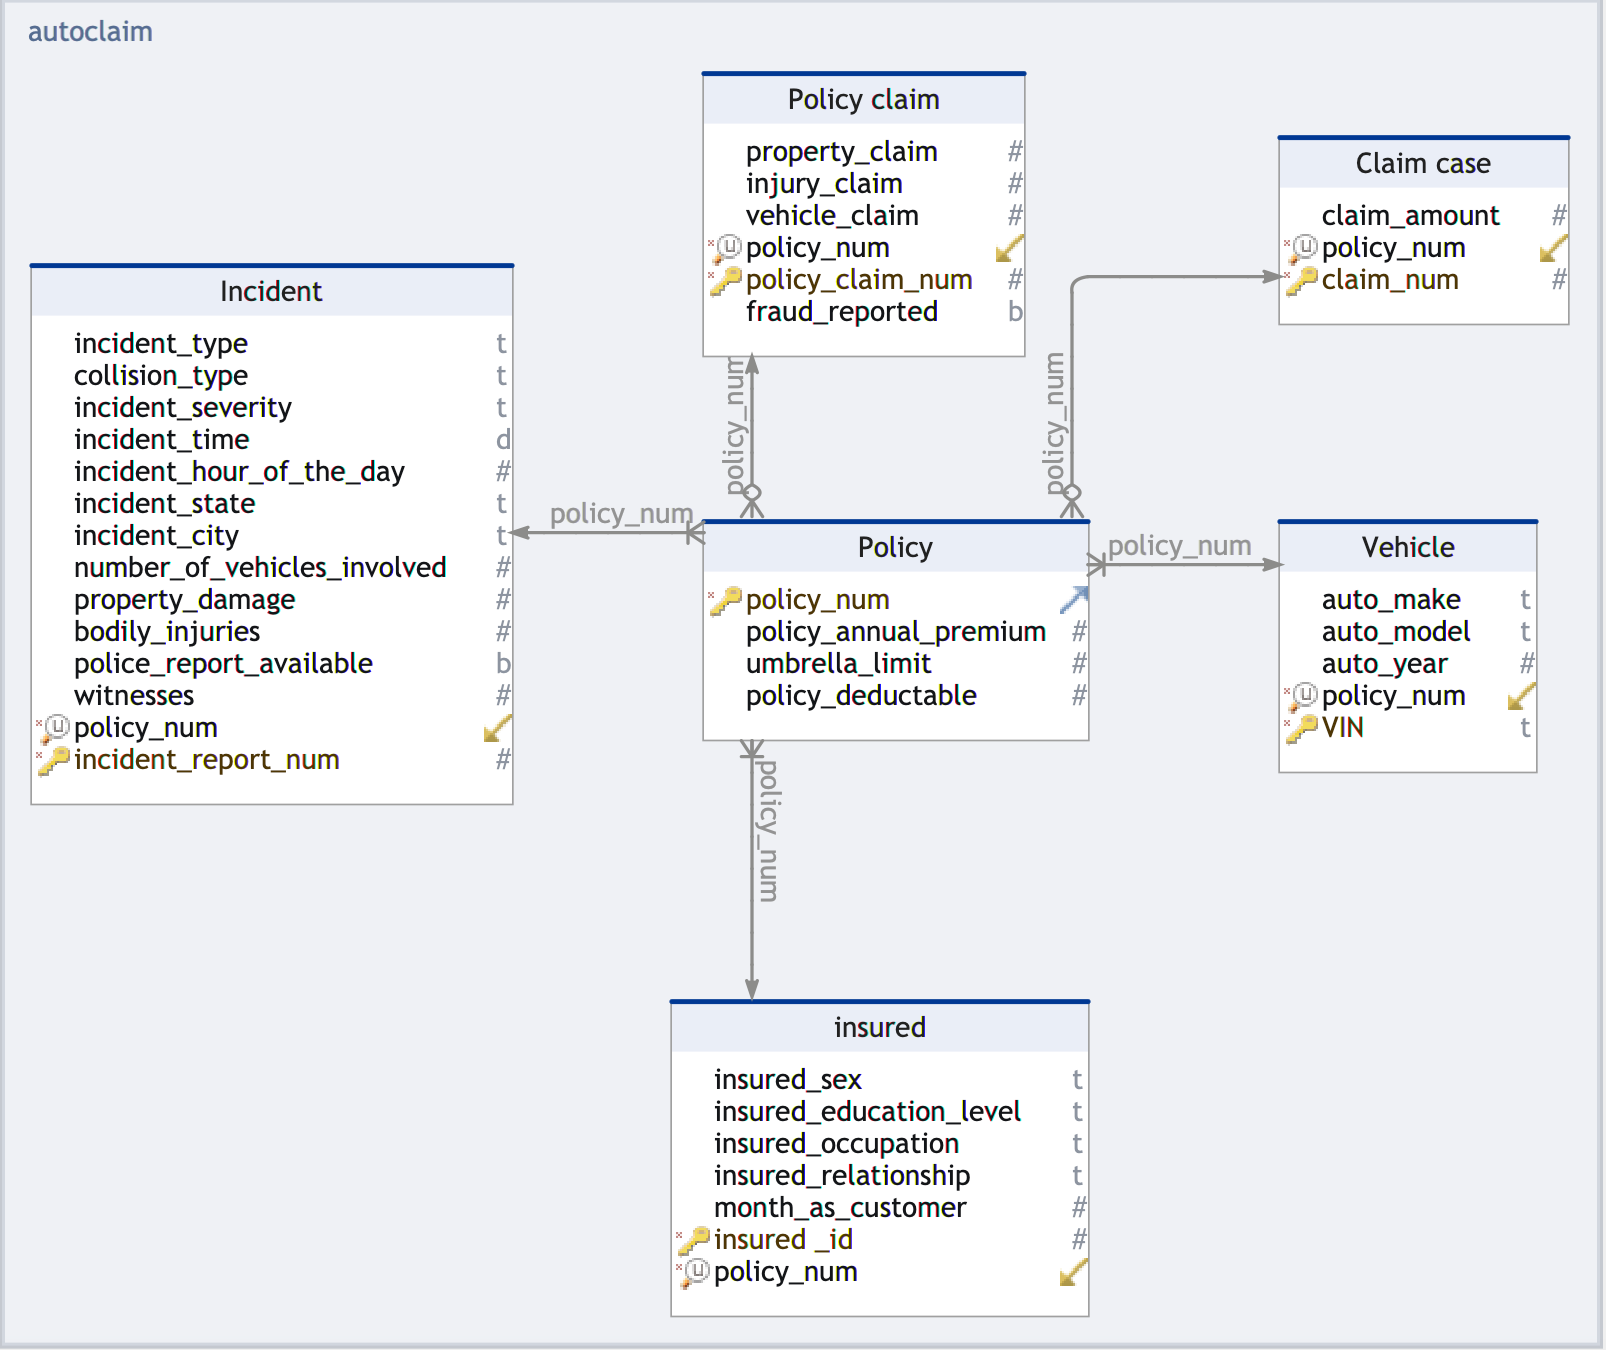

In [253]:
from IPython.display import Image
Image(filename='/Users/Courses/158739_introduction_to_analytics/assignments/assgnment_3/autoclaim_dbschema.png')

The database schema contains six tables namely client table, policy table, vehicle table, incident table, claim case table, and policy claim table. 

1. The client table includes all the data relating to individual customers who have an insurance policy, such as age, insured sex, months as customer, insured education level, or insured occupation with the primary key of insured ID. 


2. The policy table contains information about the policy such as policy number, policy annual premium, and umbrella limit with the primary key of the policy number. It is linked to the insured table through a foreign key policy number, as an insured individual or entity can have multiple policies.


3. The vehicle table describes the information about insured vehicles such as auto make, auto model, and auto year with the primary key of VIN. The "vehicle" table is associated with the "policy" table through a foreign key policy number, as a policy can cover one or more vehicles.


4. The incident table stores data about the accident involving insured vehicles. It contains columns such as incident state, incident city, incident location, the incident hour of the day, and the number of vehicles involved with the primary key of the incident report number. It is linked to the policy table through the policy number.


5. The claim case table shows the data about the car insurance claim case like the claim amount with the primary key of the claim number. It is associated with the policy table through policy number as a claim case relates to one or more specific policies. 


6. The policy claim table describes the information about claims in a single policy, including columns like property claim, injury claim, vehicle claim, and fraud reported. It is linked to the policy table through the policy number.


# 2. Database Population

First of all, I import the auto insurance claim dataset formed in assignment 4. 

Next, I create the database and set up six tables. I proceed to populate each table with the necessary data and carefully verify the accuracy of the information.

Finally, I join these six tables together into one merged table. By comparing it with the original dataset in assignment 4, it indicates that they have the same size of observations. Therefore, the data is consistent.


### 2.1 import dataset

In [185]:
#read dataset formed in assignment4
claim_final = pd.read_csv("/Users/Courses/158739_introduction_to_analytics/datasets/claim_all.csv")
pd.set_option('display.max_columns', None)
print(f'shape of dataset : {claim_final.shape}')
claim_final.head()

shape of dataset : (1000, 58)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39,Curb Weight,EPA Total Interior,Fuel Capacity,Front Head Room,Front Leg Room,Max Seating Capacity,Overall Length,Front Shoulder Room,Trunk or Cargo Capacity,Turning Diameter,Wheel Base,Width with mirrors,EPA Passenger,Minimum Ground Clearance,"Towing Capacity, Maximum",Gross Vehicle Weight Rating (GVWR),month,usexports
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN,3682,84.0,16.1,37.5,41.3,5,182.1,54.3,12.2,37.4,108.3,79.5,98.1,7.9,1500,4320,2015-01,121422.058530
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,Rear Collision,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,NO,0,0,NO,5070,780,780,3510,Mercedes,E400,2007,Y,NaN,3682,84.0,16.1,37.5,41.3,5,182.1,54.3,12.2,37.4,108.3,79.5,98.1,7.9,1500,4320,2015-01,121422.058530
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN,3682,84.0,16.1,37.5,41.3,5,182.1,54.3,12.2,37.4,108.3,79.5,98.1,7.9,1500,4320,2015-02,118221.238593
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,NO,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN,3682,84.0,16.1,37.5,41.3,5,182.1,54.3,12.2,37.4,108.3,79.5,98.1,7.9,1500,4320,2015-01,121422.058530
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,Rear Collision,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN,3682,84.0,16.1,37.5,41.3,5,182.1,54.3,12.2,37.4,108.3,79.5,98.1,7.9,1500,4320,2015-02,118221.238593


### 2.2 creating database

In [186]:
# Creates or opens a file called mySQLiteDB.sl3 with a SQLite3 DB
connection = sqlite3.connect('/Users/Courses/158739_introduction_to_analytics/datasets/claim_all.sl3')
cursor = connection.cursor()

#### insured table

In [187]:
# Drop the 'insured' table if it exists
cursor.execute('DROP TABLE IF EXISTS insured')

# Create the 'insured' table
cursor.execute('''
    CREATE TABLE insured (
        insured_id INTEGER PRIMARY KEY,
        insured_sex TEXT,
        insured_education_level TEXT,
        insured_occupation TEXT,
        months_as_customer INTEGER,
        policy_number INTEGER
    )
''')


In [188]:
# Populating 'insured' table
insured_data = claim_final[["insured_sex", "insured_education_level", "insured_occupation", "months_as_customer", "policy_number"]]
for _, row in insured_data.iterrows():
    cursor.execute("INSERT INTO insured (insured_sex, insured_education_level, insured_occupation, months_as_customer,policy_number) VALUES (?, ?, ?, ?, ? )",
                   (row["insured_sex"], row["insured_education_level"], row["insured_occupation"], row["months_as_customer"], row["policy_number"]))
connection.commit()  

In [189]:
# Check 'insured' table
cursor.execute("SELECT * FROM insured LIMIT 5")
print("\ninsured table:")
for row in cursor:
    print(row)


insured table:
(1, 'MALE', 'MD', 'craft-repair', 328, 521585)
(2, 'MALE', 'MD', 'machine-op-inspct', 228, 342868)
(3, 'FEMALE', 'PhD', 'sales', 134, 687698)
(4, 'FEMALE', 'PhD', 'armed-forces', 256, 227811)
(5, 'MALE', 'Associate', 'sales', 228, 367455)


#### policy table

In [190]:
# Drop the 'policy' table if it exists
cursor.execute('DROP TABLE IF EXISTS policy')

# Create the 'policy' table
cursor.execute('''
    CREATE TABLE policy (
        policy_number INTEGER PRIMARY KEY,
        policy_annual_premium REAL,
        fraud_reported TEXT
    )
''')

In [191]:
# Populating 'policy' table
policy_data = claim_final[["policy_number", "policy_annual_premium", "fraud_reported"]]
for _, row in policy_data.iterrows():
    cursor.execute("INSERT INTO policy (policy_number, policy_annual_premium, fraud_reported) VALUES (?, ?, ?)",
                   (row["policy_number"], row["policy_annual_premium"], row["fraud_reported"]))
connection.commit()   

In [192]:
# Check 'policy' table
cursor.execute("SELECT * FROM policy LIMIT 5")
print("\npolicy table:")
for row in cursor:
    print(row)


policy table:
(100804, 1459.96, 'N')
(101421, 1022.46, 'N')
(104594, 1351.1, 'Y')
(106186, 1389.86, 'N')
(106873, 894.4, 'N')


#### vehicle table

In [193]:
# Drop the 'vehicle' table if it exists
cursor.execute('DROP TABLE IF EXISTS vehicle')

# Create the 'vehicle' table
cursor.execute('''
    CREATE TABLE vehicle (
        vehicle_id INTEGER PRIMARY KEY,
        auto_make TEXT,
        auto_model TEXT,
        auto_year INTEGER,
        policy_number INTEGER,
        FOREIGN KEY (policy_number) REFERENCES policy(policy_number)
    )
''')

In [194]:
# Populating 'vehicle' table
vehicle_data = claim_final[["auto_make", "auto_model", "auto_year", "policy_number"]]
for _, row in vehicle_data.iterrows():
    cursor.execute("INSERT INTO vehicle (auto_make, auto_model, auto_year, policy_number) VALUES (?, ?, ?, ?)",
                   (row["auto_make"], row["auto_model"], row["auto_year"], row["policy_number"]))
connection.commit()   


In [195]:
# Check 'vehicle' table
cursor.execute("SELECT * FROM vehicle LIMIT 5")
print("\nvehicle table:")
for row in cursor:
    print(row)


vehicle table:
(1, 'Saab', '92x', 2004, 521585)
(2, 'Mercedes', 'E400', 2007, 342868)
(3, 'Dodge', 'RAM', 2007, 687698)
(4, 'Chevrolet', 'Tahoe', 2014, 227811)
(5, 'Accura', 'RSX', 2009, 367455)


#### incident table

In [196]:
# Drop the 'incident' table if it exists
cursor.execute('DROP TABLE IF EXISTS incident')

# Create the 'incident' table
cursor.execute('''
    CREATE TABLE incident (
        incident_id INTEGER PRIMARY KEY,
        incident_type TEXT,
        collision_type TEXT,
        incident_severity TEXT,
        incident_hour_of_the_day INTEGER,
        incident_state TEXT,
        incident_city TEXT,
        number_of_vehicles_involved INTEGER,
        policy_number INTEGER,
        FOREIGN KEY (policy_number) REFERENCES policy(policy_number)
    )
''')

In [197]:
# Populating 'incident' table
incident_data = claim_final[["incident_type", "collision_type", "incident_severity", "incident_hour_of_the_day", "incident_state", "incident_city", "number_of_vehicles_involved", "policy_number"]]
for _, row in incident_data.iterrows():
    cursor.execute("INSERT INTO incident (incident_type, collision_type, incident_severity, incident_hour_of_the_day, incident_state, incident_city, number_of_vehicles_involved, policy_number) VALUES (?, ?, ?, ?, ?, ?, ?, ?)",
                   (row["incident_type"], row["collision_type"], row["incident_severity"], row["incident_hour_of_the_day"], row["incident_state"], row["incident_city"], row["number_of_vehicles_involved"], row["policy_number"]))
connection.commit()   


In [198]:
# Check 'incident' table
cursor.execute("SELECT * FROM incident LIMIT 5")
print("\nincident table:")
for row in cursor:
    print(row)


incident table:
(1, 'Single Vehicle Collision', 'Side Collision', 'Major Damage', 5, 'SC', 'Columbus', 1, 521585)
(2, 'Vehicle Theft', 'Rear Collision', 'Minor Damage', 8, 'VA', 'Riverwood', 1, 342868)
(3, 'Multi-vehicle Collision', 'Rear Collision', 'Minor Damage', 7, 'NY', 'Columbus', 3, 687698)
(4, 'Single Vehicle Collision', 'Front Collision', 'Major Damage', 5, 'OH', 'Arlington', 1, 227811)
(5, 'Vehicle Theft', 'Rear Collision', 'Minor Damage', 20, 'NY', 'Arlington', 1, 367455)


#### claim case table

In [199]:
# Drop the 'claim_case' table if it exists
cursor.execute('DROP TABLE IF EXISTS claim_case')

# Create the 'claim_case' table
cursor.execute('''
    CREATE TABLE claim_case (
        case_id INTEGER PRIMARY KEY,
        total_claim_amount INTEGER,
        policy_number INTEGER,
        FOREIGN KEY (policy_number) REFERENCES policy(policy_number)
    )
''')

In [200]:
# Populating 'claim_case' table
claim_case_data = claim_final[["total_claim_amount", "policy_number"]]
for _, row in claim_case_data.iterrows():
    total_claim_amount = str(row["total_claim_amount"])
    policy_number = str(row["policy_number"])
    cursor.execute("INSERT INTO claim_case (total_claim_amount, policy_number) VALUES (?, ?)",
                   (total_claim_amount, policy_number))


In [201]:
# Check 'claim_case' table
cursor.execute("SELECT * FROM claim_case LIMIT 5")
print("\nclaim_case table:")
for row in cursor:
    print(row)



claim_case table:
(1, 71610, 521585)
(2, 5070, 342868)
(3, 34650, 687698)
(4, 63400, 227811)
(5, 6500, 367455)


#### policy claim table

In [202]:
# Drop the 'policy_claim' table if it exists
cursor.execute('DROP TABLE IF EXISTS policy_claim')

# Create the 'policy_claim' table
cursor.execute('''
    CREATE TABLE policy_claim (
        policy_claim_id INTEGER PRIMARY KEY,
        property_claim INTEGER,
        injury_claim INTEGER,
        vehicle_claim INTEGER,
        policy_number INTEGER,
        FOREIGN KEY (policy_number) REFERENCES policy(policy_number)
    )
''')
connection.commit() 

In [203]:
# Populating 'policy_claim' table
policy_claim_data = claim_final[["property_claim", "injury_claim", "vehicle_claim", "policy_number"]]
for _, row in policy_claim_data.iterrows():
    property_claim = int(row["property_claim"])
    injury_claim = int(row["injury_claim"])
    vehicle_claim = int(row["vehicle_claim"])
    policy_number = int(row["policy_number"])
    cursor.execute("INSERT INTO policy_claim (property_claim, injury_claim, vehicle_claim, policy_number) VALUES (?, ?, ?, ?)",
                   (property_claim, injury_claim, vehicle_claim, policy_number))

In [204]:
# Check 'policy_claim' table
cursor.execute("SELECT * FROM policy_claim LIMIT 5")
print("\npolicy_claim table:")
for row in cursor:
    print(row)


policy_claim table:
(1, 13020, 6510, 52080, 521585)
(2, 780, 780, 3510, 342868)
(3, 3850, 7700, 23100, 687698)
(4, 6340, 6340, 50720, 227811)
(5, 650, 1300, 4550, 367455)


In [205]:
# Execute SQL queries to count rows in each table
tables = ["insured", "policy", "vehicle", "incident", "claim_case", "policy_claim"]
for table in tables:
    sql_query = f"SELECT COUNT(*) FROM {table};"
    cursor.execute(sql_query)
    count = cursor.fetchone()[0]
    print(f"Number of rows in {table}: {count}")

Number of rows in insured: 1000
Number of rows in policy: 1000
Number of rows in vehicle: 1000
Number of rows in incident: 1000
Number of rows in claim_case: 1000
Number of rows in policy_claim: 1000


#### join the tables

In [206]:
create_claim_final_sql =  '''
CREATE TABLE claim_final_sql AS
SELECT insured.insured_sex, insured.insured_education_level, insured.insured_occupation, insured.months_as_customer,
       policy.*,
       vehicle.auto_make, vehicle.auto_model, vehicle.auto_year,
       incident.incident_type, incident.collision_type, incident.incident_severity, incident.incident_hour_of_the_day,
       incident.incident_state, incident.incident_city, incident.number_of_vehicles_involved,
       claim_case.total_claim_amount, 
       policy_claim.property_claim,  policy_claim.injury_claim,  policy_claim.vehicle_claim
FROM insured
JOIN policy ON insured.policy_number = policy.policy_number
JOIN vehicle ON insured.policy_number = vehicle.policy_number
JOIN incident ON insured.policy_number = incident.policy_number
JOIN claim_case ON insured.policy_number = claim_case.policy_number
JOIN policy_claim ON insured.policy_number = policy_claim.policy_number
'''

cursor.execute("DROP TABLE IF EXISTS claim_final_sql")
cursor.execute(create_claim_final_sql)

In [207]:
# Read in the dataset from the SQLite database
df_claim_final_sql = pd.read_sql_query("SELECT * FROM claim_final_sql", connection)

# Check the number of rows of the dataset
print("Number of rows:", df_claim_final_sql.shape[0])

df_claim_final_sql.head()

Number of rows: 1000


,insured_sex,insured_education_level,insured_occupation,months_as_customer,policy_number,policy_annual_premium,fraud_reported,auto_make,auto_model,auto_year,incident_type,collision_type,incident_severity,incident_hour_of_the_day,incident_state,incident_city,number_of_vehicles_involved,total_claim_amount,property_claim,injury_claim,vehicle_claim
0,MALE,MD,craft-repair,328,521585,1406.91,Y,Saab,92x,2004,Single Vehicle Collision,Side Collision,Major Damage,5,SC,Columbus,1,71610,13020,6510,52080
1,MALE,MD,machine-op-inspct,228,342868,1197.22,Y,Mercedes,E400,2007,Vehicle Theft,Rear Collision,Minor Damage,8,VA,Riverwood,1,5070,780,780,3510
2,FEMALE,PhD,sales,134,687698,1413.14,N,Dodge,RAM,2007,Multi-vehicle Collision,Rear Collision,Minor Damage,7,NY,Columbus,3,34650,3850,7700,23100
3,FEMALE,PhD,armed-forces,256,227811,1415.74,Y,Chevrolet,Tahoe,2014,Single Vehicle Collision,Front Collision,Major Damage,5,OH,Arlington,1,63400,6340,6340,50720
4,MALE,Associate,sales,228,367455,1583.91,N,Accura,RSX,2009,Vehicle Theft,Rear Collision,Minor Damage,20,NY,Arlington,1,6500,650,1300,4550


In [208]:
#read dataset formed in assignment4
claim_final = pd.read_csv("/Users/Courses/158739_introduction_to_analytics/datasets/claim_final.csv")
pd.set_option('display.max_columns', None)

# Check the number of rows of the dataset
print("Number of rows:", claim_final.shape[0])
claim_final.head()

Number of rows: 1000


,months_as_customer,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,1000,1406.91,0,MALE,MD,craft-repair,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,SC,Columbus,5,1,YES,1,2,YES,6510,13020,52080,Saab,92x,2004,Y
1,228,2000,1197.22,5000000,MALE,MD,machine-op-inspct,other-relative,0,0,Vehicle Theft,Rear Collision,Minor Damage,VA,Riverwood,8,1,NO,0,0,NO,780,780,3510,Mercedes,E400,2007,Y
2,134,2000,1413.14,5000000,FEMALE,PhD,sales,own-child,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,NY,Columbus,7,3,NO,2,3,NO,7700,3850,23100,Dodge,RAM,2007,N
3,256,2000,1415.74,6000000,FEMALE,PhD,armed-forces,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,OH,Arlington,5,1,NO,1,2,NO,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,1000,1583.91,6000000,MALE,Associate,sales,unmarried,66000,-46000,Vehicle Theft,Rear Collision,Minor Damage,NY,Arlington,20,1,NO,0,1,NO,1300,650,4550,Accura,RSX,2009,N


It shows that the new database has the same observations as the dataset built in assignment 4.

## 3. SQLite Queries

In this section, there are six queries that will be raised to perform some analysis of the dataset.

### Query 1 

The code below was used to create a pivot table showing the average total claim amount for insured individuals categorized by sex across different collision types.

The main techniques were used as follows:
1. using case when;
2. pivot tables;
3. group by;

In [ ]:
pivot table

In [217]:
# Load the DataFrame into the database
df.to_sql('df_claim_final_sql', connection, if_exists='replace')

# Perform pivot table using SQLite
query = '''
SELECT
    insured_sex,
    AVG(CASE WHEN collision_type = 'Side Collision' THEN total_claim_amount END) AS Side_collision_avg,
    AVG(CASE WHEN collision_type = 'Rear Collision' THEN total_claim_amount END) AS Rear_collision_avg,
    AVG(CASE WHEN collision_type = 'Front Collision' THEN total_claim_amount END) AS Front_collision_avg
FROM
    df_claim_final_sql
GROUP BY
    insured_sex
'''

# Execute the query and fetch the results into a DataFrame
pivot_df = pd.read_sql_query(query, connection)

# Print the pivot table DataFrame
pivot_df

,insured_sex,Side_collision_avg,Rear_collision_avg,Front_collision_avg
0,FEMALE,61861.666667,41982.677165,65432.406015
1,MALE,64104.126984,38512.824074,63807.355372


### Query 2
The code below was used to create a cross-tabulation that displays the counts of different damage types across various incident types.

The main techniques were used as follows:
1. using case when;
2. cross-tabulation;
3. group by;

In [216]:
# Load the DataFrame into the database
df.to_sql('df_claim_final_sql', connection, if_exists='replace')

# Perform cross-tabulation using SQLite
query2 = '''
SELECT
    incident_type,
    SUM(CASE WHEN incident_severity = 'Major Damage' THEN 1 ELSE 0 END) AS Major_Damage,
    SUM(CASE WHEN incident_severity = 'Minor Damage' THEN 1 ELSE 0 END) AS Minor_Damage
FROM
    df_claim_final_sql
GROUP BY
    incident_type
'''

# Execute the query and fetch the results into a DataFrame
cross_tabulation = pd.read_sql_query(query2, connection)


# Print the cross-tabulation
cross_tabulation

,incident_type,Major_Damage,Minor_Damage
0,Multi-vehicle Collision,144,130
1,Parked Car,0,42
2,Single Vehicle Collision,132,136
3,Vehicle Theft,0,46


### Query 3

The code below was used to create a table showing total claim amount, average of total claim amount and the difference between these two values across different types of auto make and auto model.

The main techniques were used as follows:

1. aggregation;
2. select from subtables;
3. group by;

In [222]:
# Perform aggregation
# Load the DataFrame into the database
df.to_sql('df_claim_final_sql', connection, if_exists='replace')

# Execute the SQL query and fetch the result into a DataFrame
query3 = '''
SELECT auto_make, auto_model, total_claim_amount,
        (SELECT AVG(total_claim_amount) FROM df_claim_final_sql) AS avg_total_claim, 
        total_claim_amount - (SELECT AVG(total_claim_amount) FROM df_claim_final_sql) AS difference
FROM df_claim_final_sql
GROUP BY auto_make, auto_model
'''
result = pd.read_sql_query(query3, connection)

# Print the aggregated result
result

,auto_make,auto_model,total_claim_amount,avg_total_claim,difference
0,Accura,MDX,63120,52761.94,10358.06
1,Accura,RSX,6500,52761.94,-46261.94
2,Accura,TL,72930,52761.94,20168.06
3,Audi,A3,114920,52761.94,62158.06
4,Audi,A5,51590,52761.94,-1171.94
5,BMW,3 Series,29790,52761.94,-22971.94
6,BMW,M5,40000,52761.94,-12761.94
7,BMW,X5,97080,52761.94,44318.06
8,BMW,X6,33930,52761.94,-18831.94
9,Chevrolet,Malibu,30100,52761.94,-22661.94


### Query 4

The code below was used to create a table showing different city's fraud proportions.

The main techniques were used as follows:

1. using case when;
2. join the tables;
3. where;
4. group by;
5. plotting.

In [ ]:
where+group by+plot

In [230]:
# Load the DataFrame into the database
df.to_sql('df_claim_final_sql', connection, if_exists='replace')

# SQL statement to calculate the proportions of fraud_reported
sql_statement = """
    SELECT incident_city,
           COUNT(CASE WHEN fraud_reported = 'Y' THEN 1 END) * 1.0 / COUNT(*) AS fraud_proportion
    FROM incident
    JOIN policy
    ON incident.policy_number = policy.policy_number
    WHERE incident_state = 'NY'
    GROUP BY incident_city
"""

# Execute the SQL query and fetch the result into a DataFrame
result = pd.read_sql_query(sql_statement, connection)

# Print the result
result

,incident_city,fraud_proportion
0,Arlington,0.307692
1,Columbus,0.191489
2,Hillsdale,0.205882
3,Northbend,0.235294
4,Northbrook,0.225806
5,Riverwood,0.147059
6,Springfield,0.232558


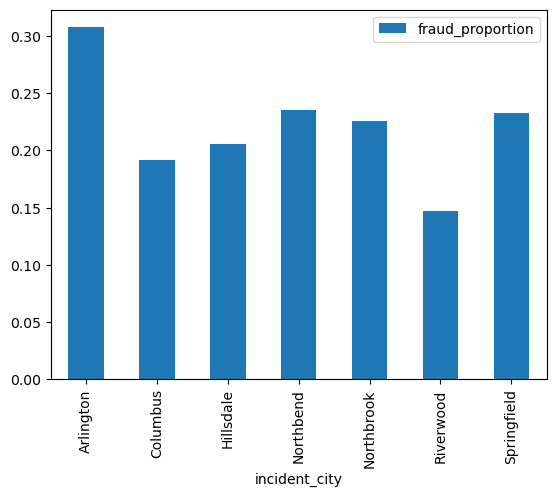

In [228]:
result.set_index('incident_city', inplace = True)
result.plot(kind = "bar");

### Query 5
The code below was used to create a table showing fraud proportion and claim rate across new-built variable client education levels.

The main techniques were used as follows:

1. using case when;
2. aggregation;
3. group by;

In [241]:
# Load the DataFrame into the database
df.to_sql('df_claim_final_sql', connection, if_exists='replace')

# Execute the SQL query to calculate client_loyalty_level and claim_rate proportions
sql_query = '''
SELECT
    CASE
        WHEN insured_education_level is "High School" or "College" THEN 'Fundamental Education'
        ELSE 'Tertiary Education'
    END AS client_education_level,
    COUNT(CASE WHEN fraud_reported = 'Y' THEN 1 END) * 1.0 / COUNT(*) AS fraud_proportion,
    SUM(total_claim_amount) / SUM(policy_annual_premium) AS claim_rate
FROM
    df_claim_final_sql
GROUP BY
    client_education_level
'''

# Execute the query and retrieve the result as a DataFrame
result_df = pd.read_sql_query(sql_query, connection)

# Print the result DataFrame
result_df

,client_education_level,fraud_proportion,claim_rate
0,Fundamental Education,0.22500,40.650389
1,Tertiary Education,0.25119,42.257228


### Query 6

The code below was used to create a table that displays the top three incident cities in states SC, VA, NY and OH associated with the highest vehicle claim amounts.

The main techniques were used as follows:
1. union multiple tables;
2. select tables from subtables;
3. order tables;
4. limit top 3.

In [245]:
# Load the DataFrame into the database
df.to_sql('df_claim_final_sql', connection, if_exists='replace')

query6 = """
SELECT "SC" AS incident_state, *
FROM (SELECT incident_state, incident_city, vehicle_claim
      FROM df_claim_final_sql
      WHERE incident_state = "SC"
      ORDER BY vehicle_claim DESC
      LIMIT 3) AS subquery1

UNION

SELECT "VA" AS incident_state, *
FROM (SELECT incident_state, incident_city, vehicle_claim
      FROM df_claim_final_sql
      WHERE incident_state = "VA"
      ORDER BY vehicle_claim DESC
      LIMIT 3) AS subquery2

UNION

SELECT "NY" AS incident_state, *
FROM (SELECT incident_state, incident_city, vehicle_claim
      FROM df_claim_final_sql
      WHERE incident_state = "NY"
      ORDER BY vehicle_claim DESC
      LIMIT 3) AS subquery3

UNION

SELECT "OH" AS incident_state, *
FROM (SELECT incident_state, incident_city, vehicle_claim
      FROM df_claim_final_sql
      WHERE incident_state = "OH"
      ORDER BY vehicle_claim DESC
      LIMIT 3) AS subquery4

ORDER BY incident_state, vehicle_claim DESC;
"""

pd.read_sql_query(query6, connection)
pd.read_sql_query(query6, connection)

# Read the result
result = pd.read_sql_query(query6, connection)
result

,incident_state,incident_state,incident_city,vehicle_claim
0,NY,NY,Hillsdale,77670
1,NY,NY,Northbend,73260
2,NY,NY,Columbus,71520
3,OH,OH,Northbend,67230
4,OH,OH,Hillsdale,59920
5,OH,OH,Columbus,54670
6,SC,SC,Springfield,79560
7,SC,SC,Springfield,77760
8,SC,SC,Riverwood,75600
9,VA,VA,Northbrook,69210


## 4. Database Views

In this section, two DB views will be created using the SQLite database to find out whether the plots are the same as those drawn in Assignment 4 or not. 

### 4.1 histograms

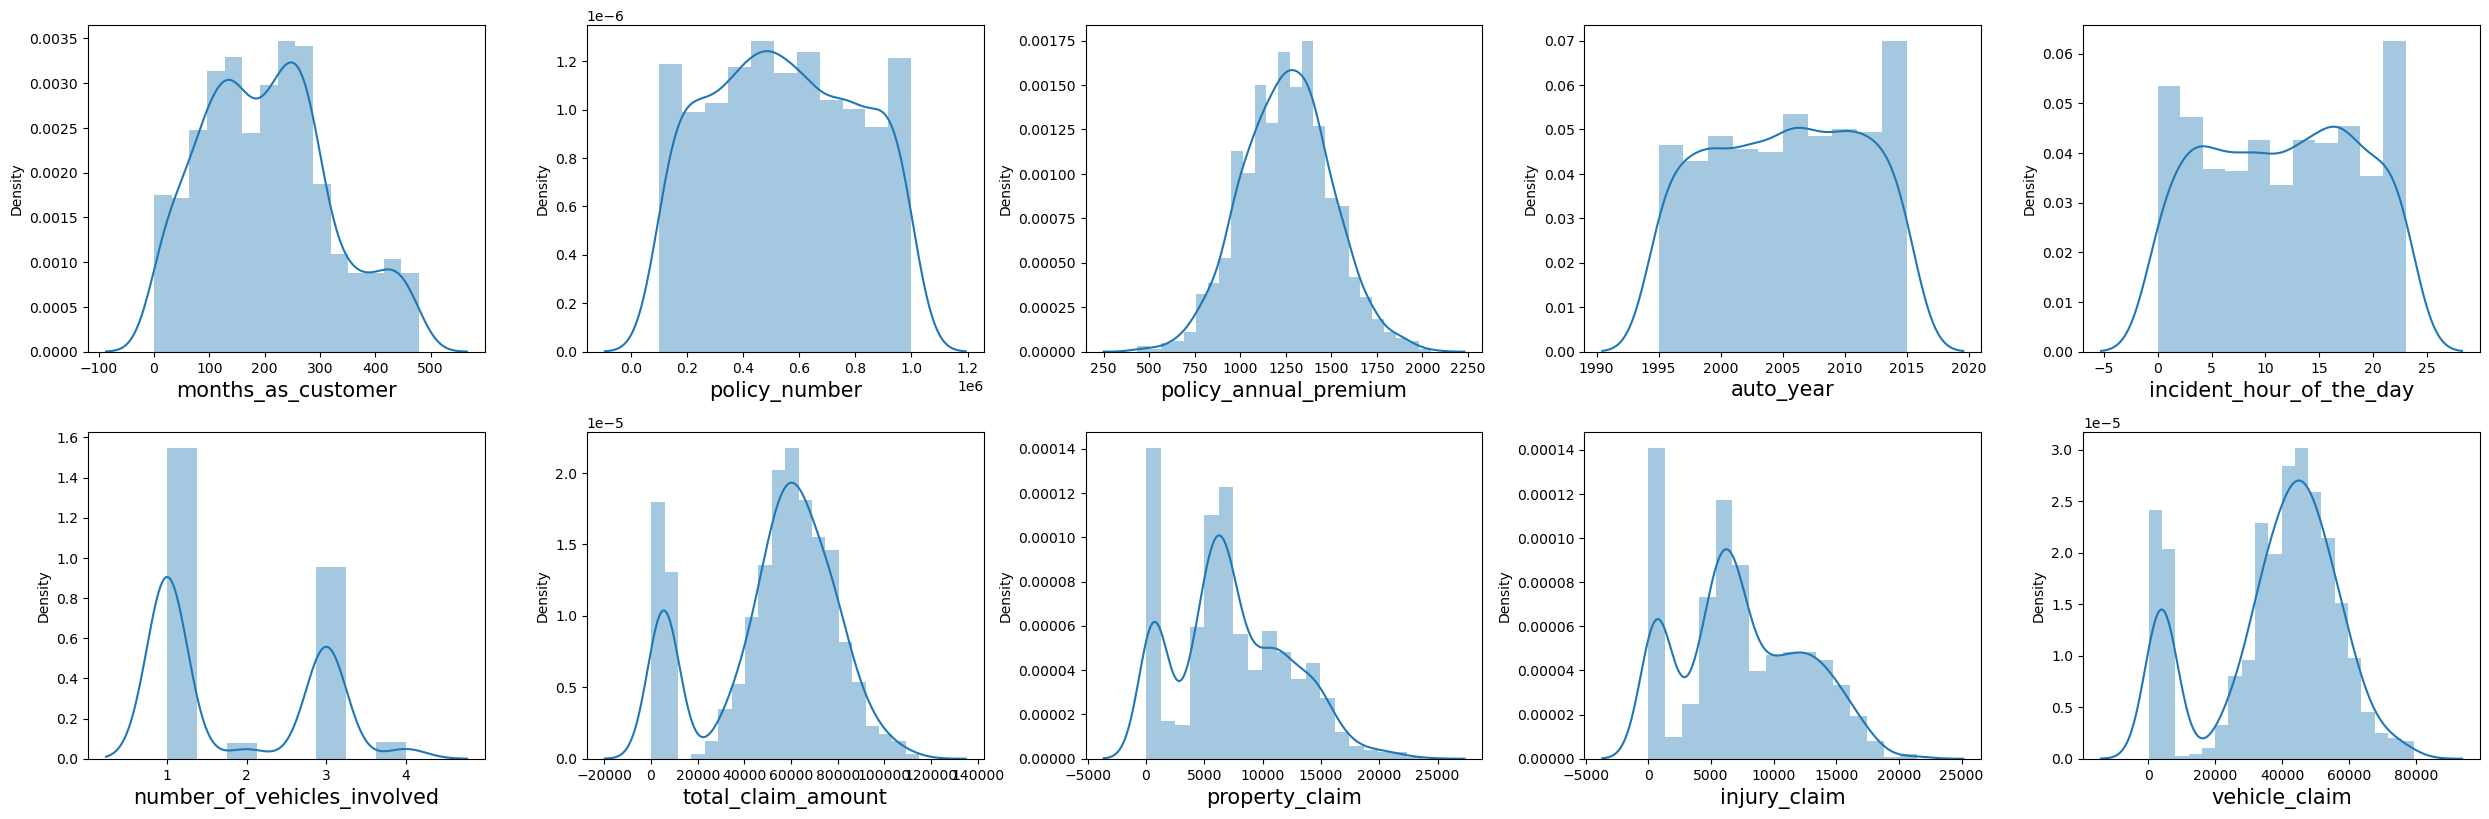

In [250]:
num_cols = df_claim_final_sql.select_dtypes(include=['int64', 'float64']).columns.tolist()

plt.figure(figsize = (25, 20))
plotnumber = 1

for col in num_cols:
    if plotnumber <= 24:
        ax = plt.subplot(5, 5, plotnumber)
        sns.distplot(df_claim_final_sql[col])
        plt.xlabel(col, fontsize = 15)
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

Fig1: distributions of numerical variables

### 4.2 boxplots

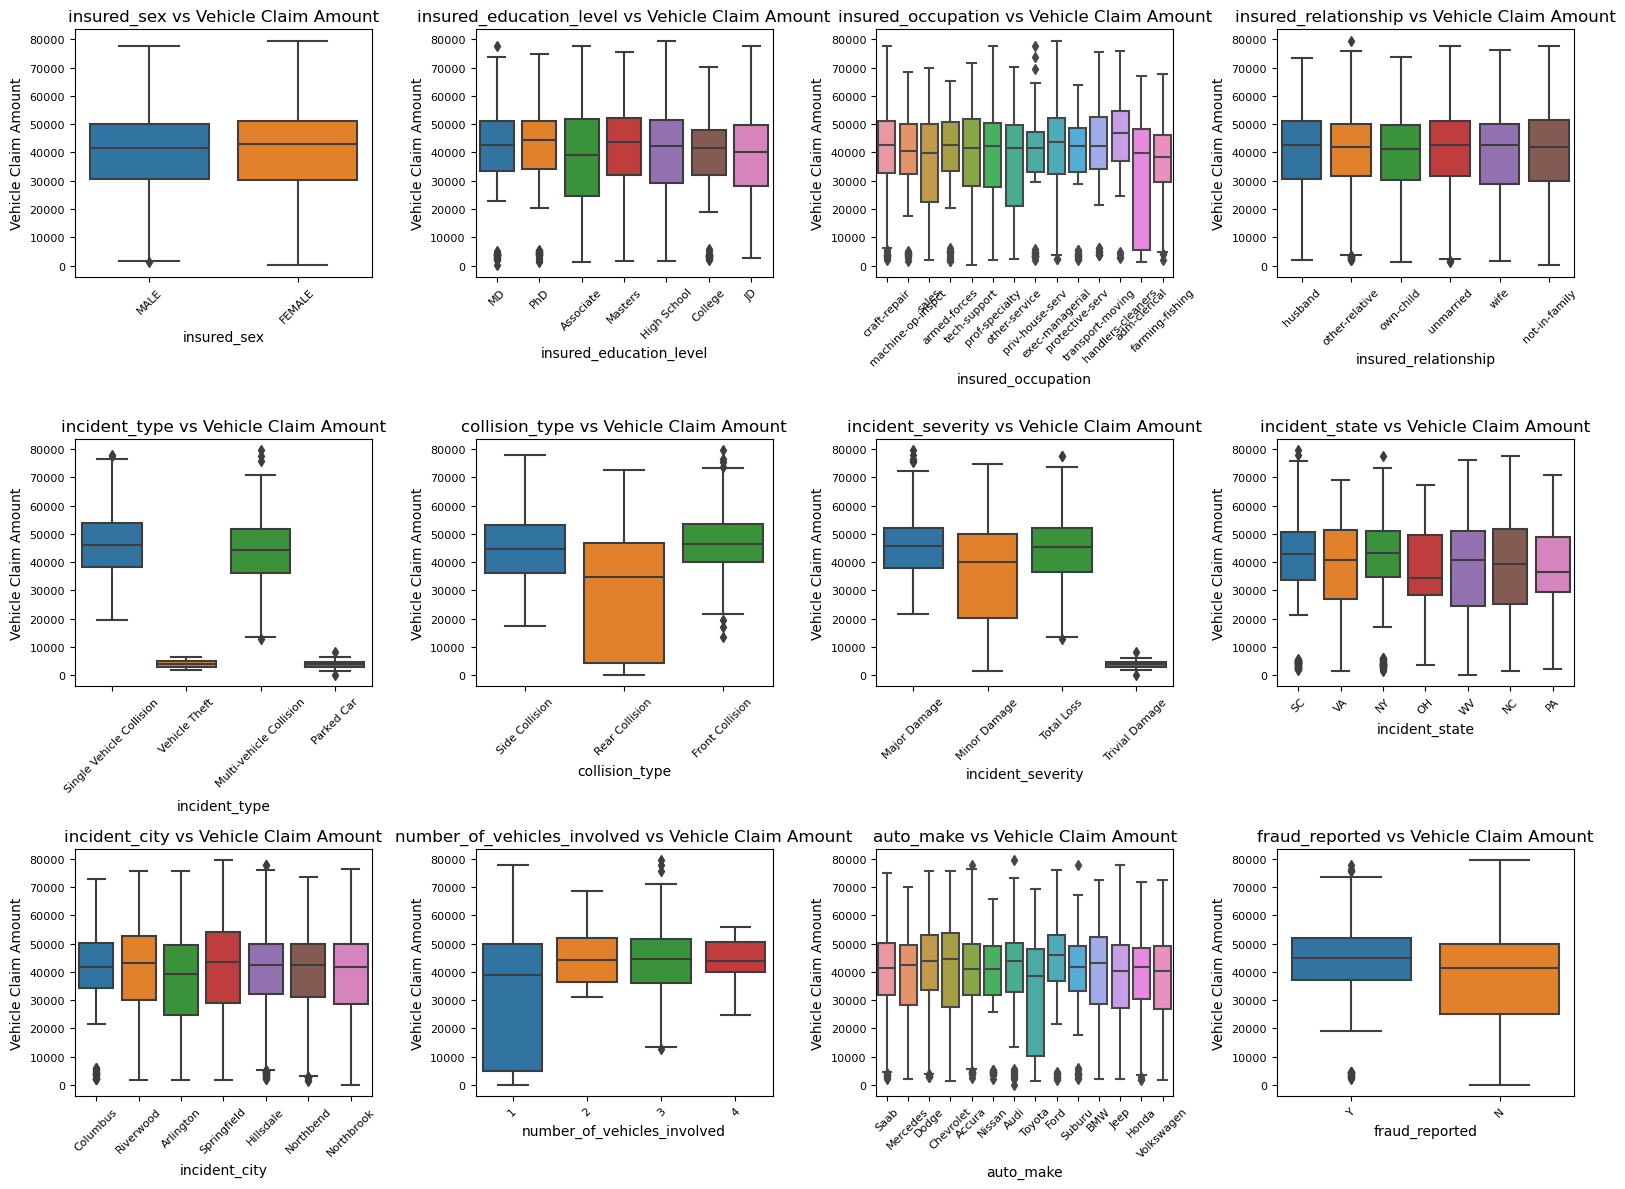

In [254]:
# visualize the relationship between categorical variables "insured_sex, insured_education_level, insured_occupation, insured_hobbies,incident_type, collision_type, number_of_vehicles_involved, auto_make" and "vehicle_claim"
# Create subplots for each categorical variable
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over each categorical variable and create box plots
for i, cat_var in enumerate(['insured_sex', 'insured_education_level', 'insured_occupation', 'insured_relationship',
                             'incident_type', 'collision_type', 'incident_severity','incident_state','incident_city',
                             'number_of_vehicles_involved', 'auto_make','fraud_reported']):
    # Create box plot
    sns.boxplot(x=cat_var, y='vehicle_claim', data=df, ax=axes[i])
    axes[i].set_title(f'{cat_var} vs Vehicle Claim Amount', fontsize=12)  # Adjust title font size
    axes[i].set_xlabel(cat_var, fontsize=10)  # Adjust x-axis label font size
    axes[i].set_ylabel('Vehicle Claim Amount', fontsize=10)  # Adjust y-axis label font size
    
        # Adjust x-axis tick label font size
    axes[i].tick_params(axis='x', labelsize=8, labelrotation=45)
    # Adjust y-axis tick label font size
    axes[i].tick_params(axis='y', labelsize=8)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Fig2: box plots of client, incident, vehicle variables across vehicle claim amount

# 5. Conclusion 


Utilizing the SQLite database for data processing generates tables that yield identical outputs as those obtained using Python.